# UMOD
Autosomal dominant tubulointerstitial kidney disease (ADTKD) is characterized by tubular damage and interstitial fibrosis in the absence of glomerular lesions, with inescapable progression to end-stage renal disease. ADTKD is caused by mutations in at least five different genes, including UMOD. UMOD, encoding uromodulin, which is the most abundant protein secreted in normal urine and has multiple roles in kidney physiology, including salt handling, protection against infections and kidney stones and immunomodulation. The primary effect of UMOD mutations is the endoplasmic reticulum (ER) retention of the mutant protein, probably due to protein misfolding ([Devuyst et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31488840/)).

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release="v2025-01-16")
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


# UMOD
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for UMOD.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'UMOD'
mane_tx_id = 'NM_003361.4'
mane_protein_id = 'NP_003352.2' # Uromodulin
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [ ]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 207/207 [00:00<00:00, 872.84 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
101,Stage 5 chronic kidney disease
64,Hyperuricemia
52,Elevated circulating creatinine concentration
44,Hypertension
43,Gout
42,Chronic kidney disease
35,Proteinuria
32,Renal cyst
27,Renal interstitial fibrosis
25,Stage 1 chronic kidney disease


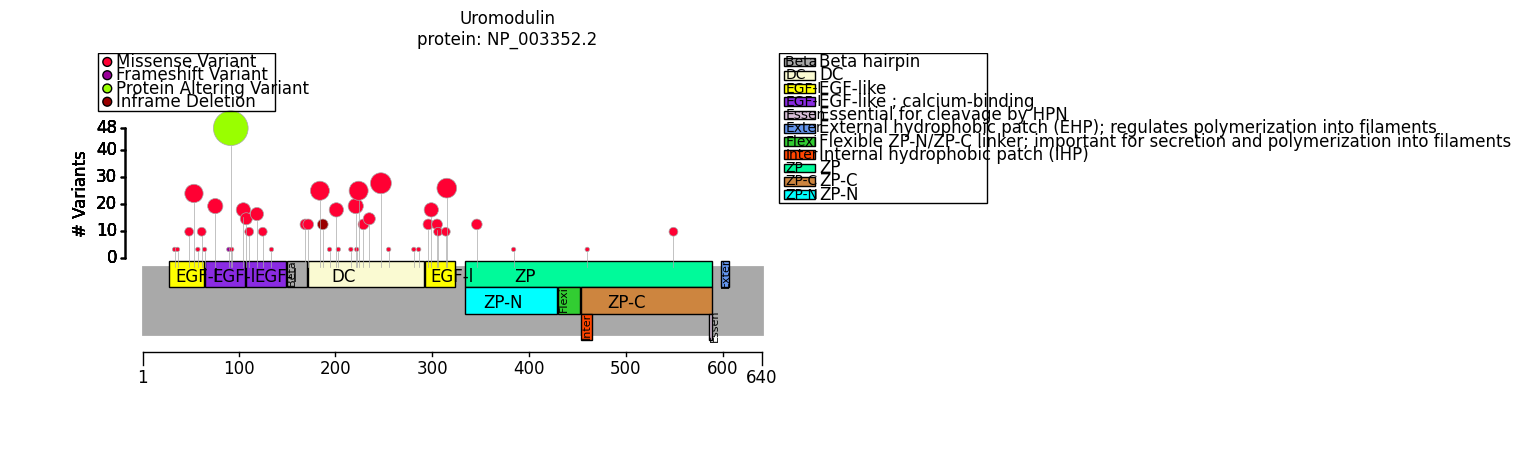

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

umod_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
umod_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
42,16_20349012_20349023_CTTCGGGGCAGA_AGGAGGCGG,c.278_289delinsCCGCCTCCT (p.Val93_Gly97delinsAlaAlaSerCys),3,protein altering
13,16_20348249_20348249_T_G,c.947A>C (p.Gln316Pro),4,missense
12,16_20348557_20348557_G_C,c.744C>G (p.Cys248Trp),3,missense
11,16_20348748_20348748_G_T,c.553C>A (p.Arg185Ser),3,missense
11,16_20349138_20349138_C_T,c.163G>A (p.Gly55Ser),3,missense
8,16_20348627_20348627_G_A,c.674C>T (p.Thr225Met),3,missense
7,16_20348636_20348636_C_G,c.665G>C (p.Arg222Pro),3,missense
6,16_20349012_20349023_CTTCGGGGCAGA_AGGAGCCGG,c.278_289delinsCCGGCTCCT (p.Val93_Gly97delinsAlaGlySerCys),3,protein altering
6,16_20348984_20348984_C_A,c.317G>T (p.Cys106Phe),3,missense
6,16_20348696_20348696_C_G,c.605G>C (p.Trp202Ser),3,missense


In [7]:
from gpsea.view import ProteinVariantViewer
pvviewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvviewer.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
18,EGF-like 1,Domain,29 - 64,p.Cys50Ser; p.Asp59Ala; p.Cys35Tyr; p.Cys63Arg; p.Gly55Ser; p.Asn38Ile
64,EGF-like 2; calcium-binding,Domain,66 - 107,p.Cys94Arg; p.Val93_Gly97delinsAlaGlySerCys; p.Cys106Phe; p.Cys77Gly; p.Leu66Pro; p.Val93_Gly97delinsAlaAlaSerCys; p.Cys77Arg; p.Cys92AlafsTer152
14,EGF-like 3; calcium-binding,Domain,109 - 149,p.Cys112Gly; p.Cys112Arg; p.Cys126Arg; p.Cys135Gly; p.Val109Glu; p.Cys120Gly
3,Beta hairpin,Region,151 - 171,p.Cys170Tyr
72,D10C,Region,173 - 291,p.Thr225Lys; p.Cys195Tyr; p.Cys223Gly; p.Cys217Gly; p.Pro173Arg; p.Arg185Leu; p.Trp202Ser; p.Thr225Met; p.Cys248Trp; p.Cys287Phe; p.Cys256Gly; p.Arg204Gly; p.Glu188_Leu221delinsVal; p.Arg185Ser; p.Thr225Arg; p.Arg222Pro; p.Cys248Ser; p.Pro236Gln; p.Cys282Arg; p.Trp230Arg
29,EGF-like 4,Domain,293 - 323,p.Cys300Gly; p.Cys315Phe; p.Cys306Ser; p.Cys297Trp; p.Lys307Thr; p.Cys300Tyr; p.Gln316Pro
7,ZP,Domain,335 - 589,p.Val550Ile; p.Arg385Trp; p.Cys347Arg; p.Ala461Glu; p.Cys347Gly
4,ZP-N,Region,335 - 429,p.Cys347Arg; p.Arg385Trp; p.Cys347Gly
0,Flexible ZP-N/ZP-C linker; important for secretion and polymerization into filaments,Region,431 - 453,
3,ZP-C,Region,455 - 589,p.Val550Ile; p.Ala461Glu


# Genotype Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate import protein_feature, anyof
from gpsea.analysis.clf import monoallelic_classifier

egf1 = protein_feature(feature_id="EGF-like 1", protein_metadata=protein_meta)
egf2 = protein_feature(feature_id="EGF-like 2; calcium-binding", protein_metadata=protein_meta)
egf3 = protein_feature(feature_id="EGF-like 3; calcium-binding", protein_metadata=protein_meta)
egf = anyof((egf1, egf2, egf3))

egf_clf = monoallelic_classifier(
    a_predicate=egf, 
    b_predicate=~egf, 
    a_label="EGF", 
    b_label="other")
egf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=egf_clf,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(egf_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,1
"Skipping ""general"" level terms",25
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),58


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=egf_result)

Allele group,EGF,other,Corrected p values,p values
Hyperuricemia [HP:0002149],14/32 (44%),50/57 (88%),0.000106,0.000018
Stage 5 chronic kidney disease [HP:0003774],52/95 (55%),49/111 (44%),0.361649,0.162065
Gout [HP:0001997],8/28 (29%),35/79 (44%),0.361649,0.180824
Chronic kidney disease [HP:0012622],82/82 (100%),106/106 (100%),1.000000,1.000000
Abnormal renal physiology [HP:0012211],82/82 (100%),107/107 (100%),1.000000,1.000000
Abnormality of the kidney [HP:0000077],85/85 (100%),109/109 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.temporal.endpoint import hpo_onset
term_id = "HP:0003774"  # Stage 5 chronic kidney disease
stage_5_endpoint = hpo_onset(hpo=hpo, term_id=term_id)

In [12]:
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
egf_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=egf_clf,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, EGF domain: {egf_survival_result.pval:.4f}")

p value, Stage 5 CKD, EGF domain: 0.2844


In [13]:
from gpsea.analysis.predicate import variant_key

delins = variant_key(key="16_20349012_20349023_CTTCGGGGCAGA_AGGAGGCGG")	# c.278_289delinsCCGCCTCCT	p.Val93_Gly97delinsAlaAlaSerCys	
delins278_289_clf = monoallelic_classifier(
    a_predicate=delins, 
    b_predicate=~delins, 
    a_label="278_289delins", 
    b_label="other")
delins_278_289_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=delins278_289_clf,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, delins: {delins_278_289_survival_result.pval:.4f}")

p value, Stage 5 CKD, delins: 0.8352


In [14]:
from gpsea.analysis.clf import sex_classifier
mf_clf = sex_classifier()

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=mf_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Hyperuricemia [HP:0002149],28/42 (67%),36/47 (77%),1.0,0.349339
Stage 5 chronic kidney disease [HP:0003774],39/79 (49%),43/88 (49%),1.0,1.000000
Chronic kidney disease [HP:0012622],70/70 (100%),79/79 (100%),1.0,1.000000
Abnormal renal physiology [HP:0012211],70/70 (100%),80/80 (100%),1.0,1.000000
Abnormality of the kidney [HP:0000077],71/71 (100%),84/84 (100%),1.0,1.000000


In [15]:
# all cysteine mutations in the cohort
from gpsea.analysis.predicate import variant_effect, VariantPredicate
from gpsea.model import Variant, VariantEffect

class CysPredicate(VariantPredicate):
    """ 
    This class determines if a variant is a missense variant affecting a reference cysteine residue
    """

    def __init__(self, tx_id):
        super().__init__()
        self._tx_id = tx_id

    def get_question(self):
        return "missense variant affecting cysteine residue"
    
    @property
    def description(self):
        return "cysteine affecting variant"
    
    @property
    def name(self):
        return "CysPredicate"
    
    @property
    def variable_name(self):
        return "cys"
    
    def test(self, variant:Variant) -> bool:
        is_missense =  variant_effect(VariantEffect.MISSENSE_VARIANT, variant.get_preferred_tx_annotation().transcript_id)
        return is_missense.test(variant) and "p.Cys" in variant.get_preferred_tx_annotation().hgvsp
        

cys = CysPredicate(tx_id=mane_tx_id)
is_cys = monoallelic_classifier(a_predicate=cys, b_predicate=~cys, a_label="cysteine", b_label="other")
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=is_cys,
    endpoint=stage_5_endpoint,
)
result.pval
cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=is_cys,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=cys_result)


Allele group,cysteine,other,Corrected p values,p values
Hyperuricemia [HP:0002149],38/41 (93%),26/48 (54%),0.000269,0.000045
Gout [HP:0001997],14/42 (33%),29/65 (45%),0.940405,0.313468
Stage 5 chronic kidney disease [HP:0003774],33/69 (48%),68/137 (50%),1.000000,0.882842
Chronic kidney disease [HP:0012622],62/62 (100%),126/126 (100%),1.000000,1.000000
Abnormal renal physiology [HP:0012211],62/62 (100%),127/127 (100%),1.000000,1.000000
Abnormality of the kidney [HP:0000077],67/67 (100%),127/127 (100%),1.000000,1.000000


In [16]:
r185s = variant_key("16_20348748_20348748_G_T") # c.553C>A	p.Arg185Ser
q316p = variant_key("16_20348249_20348249_T_G") # c.947A>C	p.Gln316Pro	
c248w = variant_key("16_20348557_20348557_G_C") # c.744C>G	p.Cys248Trp	

c248w_vs_q316p = monoallelic_classifier(
    a_predicate=c248w, 
    b_predicate=q316p,
    a_label="Cys248Trp",
    b_label="Gln316Pro")
c248w_vs_q316p_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=c248w_vs_q316p,
    endpoint=stage_5_endpoint,
)
print(f"p value, Stage 5 CKD, c248w vs q316p variant: {c248w_vs_q316p_survival_result.pval:.5f}")

p value, Stage 5 CKD, c248w vs q316p variant: 0.00041


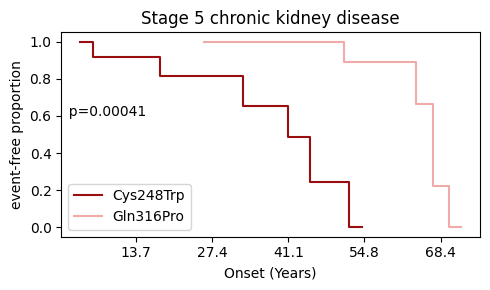

In [17]:
from gpsea.model import Age
from matplotlib.ticker import FuncFormatter


umod_surv, ax = plt.subplots(figsize=(5, 3))
c248w_vs_q316p_survival_result.plot_kaplan_meier_curves(ax=ax)

def days_to_years(x, pos):
    return f"{x / Age.DAYS_IN_YEAR:.1f}"

ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))

# Add labels
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Stage 5 chronic kidney disease")
ax.text(x=36,y=0.6, s=f"  p={c248w_vs_q316p_survival_result.pval:.5f}")
plt.tight_layout()
plt.show()

# Summary

In [18]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
  GPAnalysisResultSummary.from_multi( result=egf_result,  ),
  GPAnalysisResultSummary.from_multi( result=mf_result,  ),
  GPAnalysisResultSummary.from_multi( result=cys_result,  ),
)

m_results = (
  GPAnalysisResultSummary.from_mono(egf_survival_result),
  GPAnalysisResultSummary.from_mono(delins_278_289_survival_result),
  GPAnalysisResultSummary.from_mono(c248w_vs_q316p_survival_result),
)

caption = """One study on UMOD variants showed that median ages at ESRD development were lowest with Cys77Tyr 
and highest with Gln316Pro \\cite{PMID_23723338}, which is compatible with our finding here. Another showed that
indel mutation p.Val93_Gly97delinsAlaAlaSerCys is associated with a relatively mild clinical UAKD phenotype \\cite{PMID_22034507}. We did
not observe a significant association between this variant and age of onset with our dataset."""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [19]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [20]:
summarizer.process_latex(report=report, protein_fig=umod_fig, stats_fig=umod_surv)

Figure saved to ../../supplement/img/UMOD_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/UMOD_stats-draft.pdf
Output to ../../supplement/tex/UMOD_summary_draft.tex
